**Importing libraries**

In [35]:
%matplotlib inline
import os
import IPython.display as ipd
from IPython.display import Image

import pandas as pd
import numpy as np
import scipy
import utils

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold


import keras
from keras.optimizers import Adagrad

import tensorflow as tf

from tslearn.shapelets import LearningShapelets
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.utils import ts_size

In [36]:
#conda install -c conda-forge pyts
#conda install -c conda-forge tslearn

**Datasets**

In [37]:
tracks_df = utils.load('/Users/AlessandroVavala/Desktop/DM2 project/data/tracks.csv')
genres = tracks_df['track'][['genre_top']]
df = pd.read_csv("/Users/AlessandroVavala/Desktop/DM2 project/data/ts_spectral_dataset.csv")

df = pd.DataFrame(df.merge(genres, on = "track_id"))

df.head()

,track_id,0,1,2,3,4,5,6,7,8,...,304,305,306,307,308,309,310,311,312,genre_top
0,24367,0.085363,0.123300,0.186896,0.425724,0.744651,0.699302,0.436836,0.280918,0.338212,...,0.746991,0.759722,0.727513,0.672869,0.555858,0.398144,0.421361,0.438947,0.382448,International
1,24429,0.264956,0.268745,0.230142,0.240140,0.341539,0.259492,0.305531,0.737979,0.846997,...,0.410826,0.287059,0.322276,0.260415,0.262095,0.450971,0.797629,0.884369,0.544436,Hip-Hop
2,24428,0.164675,0.189820,0.269291,0.458719,0.717929,0.765484,0.719605,0.554262,0.393407,...,0.958382,0.495355,0.367871,0.372272,0.491252,0.610024,0.492526,0.385889,0.246126,Hip-Hop
3,24366,0.221724,0.220514,0.215578,0.238054,0.303383,0.342752,0.360302,0.419898,0.310644,...,0.549203,0.578282,0.578820,0.582818,0.486484,0.620029,0.743045,0.728486,0.663731,International
4,24364,0.148205,0.231516,0.405382,0.495909,0.641207,0.727144,0.598511,0.470844,0.459241,...,0.258943,0.317707,0.433801,0.517086,0.336307,0.202596,0.260032,0.559153,0.801095,International


In [38]:
# set index
df.set_index("track_id")

,0,1,2,3,4,5,6,7,8,9,...,304,305,306,307,308,309,310,311,312,genre_top
track_id,,,,,,,,,,,,,,,,,,,,,
24367,0.085363,0.123300,0.186896,0.425724,0.744651,0.699302,0.436836,0.280918,0.338212,0.787754,...,0.746991,0.759722,0.727513,0.672869,0.555858,0.398144,0.421361,0.438947,0.382448,International
24429,0.264956,0.268745,0.230142,0.240140,0.341539,0.259492,0.305531,0.737979,0.846997,0.583225,...,0.410826,0.287059,0.322276,0.260415,0.262095,0.450971,0.797629,0.884369,0.544436,Hip-Hop
24428,0.164675,0.189820,0.269291,0.458719,0.717929,0.765484,0.719605,0.554262,0.393407,0.361671,...,0.958382,0.495355,0.367871,0.372272,0.491252,0.610024,0.492526,0.385889,0.246126,Hip-Hop
24366,0.221724,0.220514,0.215578,0.238054,0.303383,0.342752,0.360302,0.419898,0.310644,0.440567,...,0.549203,0.578282,0.578820,0.582818,0.486484,0.620029,0.743045,0.728486,0.663731,International
24364,0.148205,0.231516,0.405382,0.495909,0.641207,0.727144,0.598511,0.470844,0.459241,0.358547,...,0.258943,0.317707,0.433801,0.517086,0.336307,0.202596,0.260032,0.559153,0.801095,International
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60857,0.187511,0.221917,0.341134,0.448006,0.522258,0.372411,0.285088,0.304237,0.393670,0.420319,...,0.256603,0.239646,0.191859,0.183835,0.240502,0.378255,0.486332,0.537792,0.645452,International
60472,0.598845,0.546697,0.479259,0.489852,0.496964,0.382337,0.340672,0.424705,0.410133,0.188110,...,0.047748,0.118704,0.307374,0.196006,0.113833,0.073183,0.099410,0.144698,0.094122,Hip-Hop
60476,0.334377,0.392237,0.353285,0.249330,0.195313,0.332864,0.783426,0.884670,0.957037,0.816459,...,0.333113,0.365477,0.679506,0.993098,0.990776,0.931001,0.785604,0.648898,0.641922,Hip-Hop


In [39]:
# genres distributions
df["genre_top"].value_counts()

International          663
Experimental           559
Pop                    495
Hip-Hop                495
Folk                   464
Electronic             417
Rock                   406
Instrumental           116
Spoken                   0
Soul-RnB                 0
Old-Time / Historic      0
Jazz                     0
Easy Listening           0
Country                  0
Classical                0
Blues                    0
Name: genre_top, dtype: int64

In [40]:
# filtering data frame
# we eliminate the song with international and Experimental genre
to_keep = ["Hip-Hop", "Pop", "Folk", "Electronic", "Rock", "Instrumental"]

# make a copy
dk = df.copy()

dk = pd.DataFrame(dk[dk.genre_top.isin(to_keep)])

dk

,track_id,0,1,2,3,4,5,6,7,8,...,304,305,306,307,308,309,310,311,312,genre_top
1,24429,0.264956,0.268745,0.230142,0.240140,0.341539,0.259492,0.305531,0.737979,0.846997,...,0.410826,0.287059,0.322276,0.260415,0.262095,0.450971,0.797629,0.884369,0.544436,Hip-Hop
2,24428,0.164675,0.189820,0.269291,0.458719,0.717929,0.765484,0.719605,0.554262,0.393407,...,0.958382,0.495355,0.367871,0.372272,0.491252,0.610024,0.492526,0.385889,0.246126,Hip-Hop
34,24420,0.617364,0.639894,0.669198,0.650944,0.631626,0.639445,0.642546,0.654701,0.660917,...,0.651839,0.661491,0.674903,0.543885,0.503333,0.637187,0.750049,0.683056,0.643569,Hip-Hop
36,24421,0.170942,0.124142,0.113361,0.287766,0.369060,0.354406,0.329190,0.305156,0.425817,...,0.440615,0.422593,0.379194,0.315963,0.331022,0.420957,0.432961,0.315307,0.171199,Hip-Hop
37,24423,0.443269,0.498263,0.629493,0.605793,0.433108,0.216362,0.192917,0.421347,0.479816,...,0.537340,0.743088,0.742118,0.496100,0.681038,1.000000,0.874307,0.507966,0.537100,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3608,60510,0.898441,0.968442,0.800646,0.495042,0.712317,0.467183,0.380134,0.240988,0.146931,...,0.104242,0.120835,0.242348,0.309884,0.186136,0.138049,0.088134,0.398768,0.577819,Hip-Hop
3611,60472,0.598845,0.546697,0.479259,0.489852,0.496964,0.382337,0.340672,0.424705,0.410133,...,0.047748,0.118704,0.307374,0.196006,0.113833,0.073183,0.099410,0.144698,0.094122,Hip-Hop
3612,60476,0.334377,0.392237,0.353285,0.249330,0.195313,0.332864,0.783426,0.884670,0.957037,...,0.333113,0.365477,0.679506,0.993098,0.990776,0.931001,0.785604,0.648898,0.641922,Hip-Hop
3613,60477,0.504701,0.639291,0.998870,0.971278,0.690408,0.389226,0.357374,0.266731,0.201811,...,0.273218,0.535751,0.622576,0.634011,0.530171,0.533951,0.642150,0.669808,0.651844,Hip-Hop


In [41]:
#function to label the song
def change_genre(row):
        if row["genre_top"] == "Hip-Hop":
            return 1
        else: 
            return 0

In [42]:
#appy function
dk['genre_top']=dk.apply (lambda row: change_genre(row), axis=1)

dk.head()
dk["genre_top"].value_counts()

0    1898
1     495
Name: genre_top, dtype: int64

In [43]:
dk = dk.set_index("track_id")
dk.head()

,0,1,2,3,4,5,6,7,8,9,...,304,305,306,307,308,309,310,311,312,genre_top
track_id,,,,,,,,,,,,,,,,,,,,,
24429,0.264956,0.268745,0.230142,0.240140,0.341539,0.259492,0.305531,0.737979,0.846997,0.583225,...,0.410826,0.287059,0.322276,0.260415,0.262095,0.450971,0.797629,0.884369,0.544436,1
24428,0.164675,0.189820,0.269291,0.458719,0.717929,0.765484,0.719605,0.554262,0.393407,0.361671,...,0.958382,0.495355,0.367871,0.372272,0.491252,0.610024,0.492526,0.385889,0.246126,1
24420,0.617364,0.639894,0.669198,0.650944,0.631626,0.639445,0.642546,0.654701,0.660917,0.649240,...,0.651839,0.661491,0.674903,0.543885,0.503333,0.637187,0.750049,0.683056,0.643569,1
24421,0.170942,0.124142,0.113361,0.287766,0.369060,0.354406,0.329190,0.305156,0.425817,0.636324,...,0.440615,0.422593,0.379194,0.315963,0.331022,0.420957,0.432961,0.315307,0.171199,1
24423,0.443269,0.498263,0.629493,0.605793,0.433108,0.216362,0.192917,0.421347,0.479816,0.557511,...,0.537340,0.743088,0.742118,0.496100,0.681038,1.000000,0.874307,0.507966,0.537100,1


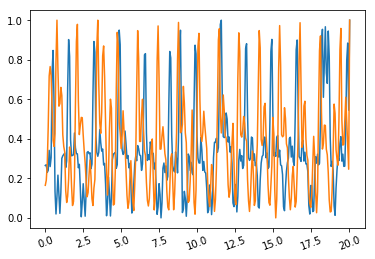

In [44]:
#Leggo la Time Series e plotto
ts_Multi = dk[0:2]
ts_Multi_transposed = ts_Multi.T # or df1.transpose()
seconds = np.arange(len(ts_Multi_transposed))*512/8000

plt.plot(seconds, ts_Multi_transposed)
plt.xticks(rotation=20)
plt.show()

In [45]:
ts_Multi

,0,1,2,3,4,5,6,7,8,9,...,304,305,306,307,308,309,310,311,312,genre_top
track_id,,,,,,,,,,,,,,,,,,,,,
24429,0.264956,0.268745,0.230142,0.240140,0.341539,0.259492,0.305531,0.737979,0.846997,0.583225,...,0.410826,0.287059,0.322276,0.260415,0.262095,0.450971,0.797629,0.884369,0.544436,1
24428,0.164675,0.189820,0.269291,0.458719,0.717929,0.765484,0.719605,0.554262,0.393407,0.361671,...,0.958382,0.495355,0.367871,0.372272,0.491252,0.610024,0.492526,0.385889,0.246126,1


In [46]:
ts_Multi_transposed

track_id,24429,24428
0,0.264956,0.164675
1,0.268745,0.189820
2,0.230142,0.269291
3,0.240140,0.458719
4,0.341539,0.717929
...,...,...
309,0.450971,0.610024
310,0.797629,0.492526
311,0.884369,0.385889
312,0.544436,0.246126


---
# Shapets-distance classifiers

This classifiers are based just only on distances between shapelets

In [48]:
features = [col for col in dk.columns if col != 'genre_top']

X = dk[features].values
y = dk['genre_top']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [49]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

# shapelets of size 31 and take in cosideration top 5

n_ts 1675
ts_sz 313
n_classes 2
shapelet_sizes {31: 5}


In [50]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=200,
                            random_state=42,
                            verbose=1)

# fit model
shp_clf.fit(X_train, y_train)

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/tslearn/shapelets/shapelets.py:357: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  FutureWarning)


Train on 1675 samples
Epoch 1/200
1675/1675 [==============================] - 5s 3ms/sample - loss: 0.5849 - binary_accuracy: 0.7791 - binary_crossentropy: 0.5772
Epoch 2/200
1675/1675 [==============================] - 2s 950us/sample - loss: 0.5115 - binary_accuracy: 0.7934 - binary_crossentropy: 0.5044
Epoch 3/200
1675/1675 [==============================] - 2s 957us/sample - loss: 0.5089 - binary_accuracy: 0.7934 - binary_crossentropy: 0.5040
Epoch 4/200
1675/1675 [==============================] - 2s 1ms/sample - loss: 0.5070 - binary_accuracy: 0.7934 - binary_crossentropy: 0.5032 1s - loss: 0.5451 - binary_accuracy: 0.7625 -
Epoch 5/200
1675/1675 [==============================] - 2s 1ms/sample - loss: 0.5089 - binary_accuracy: 0.7934 - binary_crossentropy: 0.5051
Epoch 6/200
1675/1675 [==============================] - 2s 1ms/sample - loss: 0.5066 - binary_accuracy: 0.7934 - binary_crossentropy: 0.5028
Epoch 7/200
1675/1675 [==============================] - 2s 910us/sample - l

1675/1675 [==============================] - 2s 978us/sample - loss: 0.4860 - binary_accuracy: 0.7922 - binary_crossentropy: 0.4747
Epoch 111/200
1675/1675 [==============================] - 2s 1ms/sample - loss: 0.4852 - binary_accuracy: 0.7916 - binary_crossentropy: 0.4737
Epoch 112/200
1675/1675 [==============================] - 2s 1ms/sample - loss: 0.4876 - binary_accuracy: 0.7934 - binary_crossentropy: 0.4761
Epoch 113/200
1675/1675 [==============================] - 1s 795us/sample - loss: 0.4881 - binary_accuracy: 0.7940 - binary_crossentropy: 0.4767
Epoch 114/200
1675/1675 [==============================] - 1s 815us/sample - loss: 0.4855 - binary_accuracy: 0.7940 - binary_crossentropy: 0.4740
Epoch 115/200
1675/1675 [==============================] - 2s 901us/sample - loss: 0.4880 - binary_accuracy: 0.7928 - binary_crossentropy: 0.4764
Epoch 116/200
1675/1675 [==============================] - 2s 1ms/sample - loss: 0.4854 - binary_accuracy: 0.7934 - binary_crossentropy: 0.473

LearningShapelets(batch_size=16, max_iter=200, n_shapelets_per_size={31: 5},
                  optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd9ca8b3470>,
                  random_state=42, verbose=1, weight_regularizer=0.01)

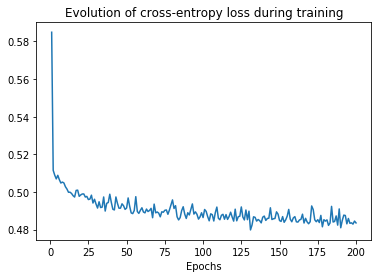

In [51]:
# The loss history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(np.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

In [52]:
# visualize location
predicted_locations = shp_clf.locate(X)

2393/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Visualize shapelets

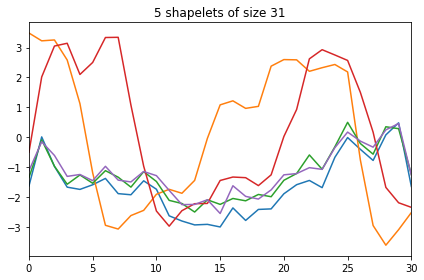

In [53]:
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()

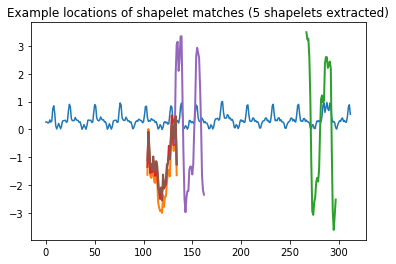

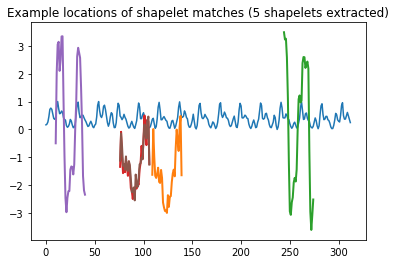

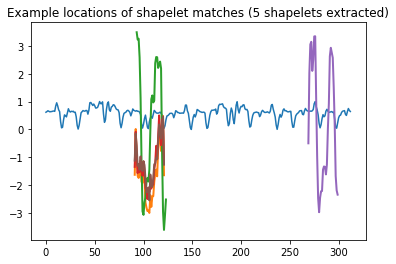

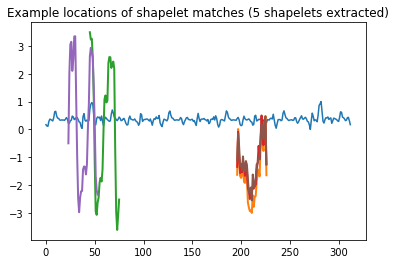

In [54]:
ts_id = [0, 1, 2, 3]

for ts in ts_id:
    plt.figure()
    n_shapelets = sum(shapelet_sizes.values())
    plt.title("Example locations of shapelet matches "
          "(5 shapelets extracted)")
    
    plt.plot(X[ts].ravel())
    for idx_shp, shp in enumerate(shp_clf.shapelets_):
        t0 = predicted_locations[ts, idx_shp]
        plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

In [20]:
# transorm training set

X_trans = shp_clf.transform(X)
X_train_trans = shp_clf.transform(X_train)
X_test_trans = shp_clf.transform(X_test)

2393/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

1675/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

718/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [21]:
print(X_train_trans.shape)
print(X_test_trans.shape)
print(X_trans.shape)

(1675, 5)
(718, 5)
(2393, 5)


### - Logistic Regressor

In [25]:
from sklearn.linear_model import LogisticRegression

param_list = {'penalty': ['l2' , 'l1'],
              'C' : np.logspace(-4, 4,20),
              'solver' : ['lbfgs', 'liblinear']
             }

log = LogisticRegression(max_iter = 200)
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats= 10, random_state=123)
cvs = []
results = []

random_search = RandomizedSearchCV(log, param_distributions = param_list, n_iter=100, cv = skf)

random_search.fit(X_train_trans, y_train)

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_t

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarnin

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/AlessandroVavala/.conda/envs/keras_t

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.con

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.con

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.con

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.con

/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.conda/envs/keras_tenserflow/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/AlessandroVavala/.con

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=123),
                   estimator=LogisticRegression(max_iter=200), n_iter=100,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'penalty': ['l2', 'l1'],
                                        'solver': ['lbfgs', 'liblinear']})

In [31]:
report_verbose(random_search.cv_results_, n_top=2)

Model with rank: 1
Mean validation score: 0.823 (std: 0.018)
Model with rank: 1
Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 11.288378916846883}

Model with rank: 2
Mean validation score: 0.823 (std: 0.018)
Model with rank: 2
Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.615848211066026}



In [28]:
print(random_search.best_estimator_)

log = random_search.best_estimator_
log = log.fit(X_train_trans, y_train)
y_pred = log.predict(X_test_trans)
y_pred_tr = log.predict(X_train_trans)

LogisticRegression(C=11.288378916846883, max_iter=200, solver='liblinear')


In [29]:
print("******* Metrics on training set *******")
print(" ")

print('Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Metrics on test set *******")
print(" ")


print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Confusion matrix test set *******")

confusion_matrix(y_test, y_pred)

******* Metrics on training set *******
 
Accuracy 0.8244776119402986
F1-score [0.89770355 0.38235294]
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1329
           1       0.70      0.26      0.38       346

    accuracy                           0.82      1675
   macro avg       0.77      0.62      0.64      1675
weighted avg       0.81      0.82      0.79      1675

__________________________________________________________
__________________________________________________________
 
******* Metrics on test set *******
 
Accuracy 0.7980501392757661
F1-score [0.88220959 0.29268293]
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       569
           1       0.54      0.20      0.29       149

    accuracy                           0.80       718
   macro avg       0.68      0.58      0.59       718
weighted avg       0.76      0.80      0.76       718

________________________

array([[543,  26],
       [119,  30]])


###  - KNN

In [30]:
def report(results, n_top=3):
    md = []
    ms = []
    ml = []
    cr = []
    mean = []
    std = []
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            mean.append( results['mean_test_score'][candidate])
            std.append(results['std_test_score'][candidate])
            ms.append(random_search.cv_results_['params'][candidate]['min_samples_split'])
            ml.append(random_search.cv_results_['params'][candidate]['min_samples_leaf'])
            cr.append(random_search.cv_results_['params'][candidate]['criterion'])
            md.append(random_search.cv_results_['params'][candidate]['max_depth'])
    dres = pd.DataFrame()
    dres['Mean Test Score'] = mean
    dres['Standard Deviation Test Score'] = std
    dres['Min Sample Leaf'] = ml
    dres['Min Sample Split'] = ms
    dres['Criterion'] = cr
    dres['Max Depth'] = md
    
    return dres

def report_verbose(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Model with rank: {0}".format(i))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold


param_list = { 'metric' : ['euclidean', 'manhattan', 'minkowski'],
    'n_neighbors' : [1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15],
     'algorithm': ['ball_tree', 'kd_tree','brute'],
    'weights': ['distance','uniform'],
}

knn = KNeighborsClassifier()
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats= 10, random_state=123)

random_search = RandomizedSearchCV(knn, param_distributions=param_list, n_iter = 100 , cv = rskf, n_jobs = -1)

random_search.fit(X_train_trans, y_train)

report_verbose(random_search.cv_results_, n_top=2)

Model with rank: 1
Mean validation score: 0.816 (std: 0.020)
Model with rank: 1
Parameters: {'weights': 'distance', 'n_neighbors': 14, 'metric': 'manhattan', 'algorithm': 'brute'}

Model with rank: 2
Mean validation score: 0.816 (std: 0.018)
Model with rank: 2
Parameters: {'weights': 'uniform', 'n_neighbors': 15, 'metric': 'manhattan', 'algorithm': 'kd_tree'}

Model with rank: 2
Mean validation score: 0.816 (std: 0.018)
Model with rank: 2
Parameters: {'weights': 'uniform', 'n_neighbors': 15, 'metric': 'manhattan', 'algorithm': 'brute'}



In [25]:
print("The best parameters combination for is:", random_search.best_estimator_ )
#fit the model
knn = random_search.best_estimator_
knn = knn.fit(X_train_trans, y_train)
y_pred = knn.predict(X_test_trans)
y_pred_tr = knn.predict(X_train_trans)

The best parameters combination for is: KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=14,
                     weights='distance')


In [26]:
print("******* Metrics on training set *******")
print(" ")

print('Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Metrics on test set *******")
print(" ")


print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Confusion matrix test set *******")

confusion_matrix(y_test, y_pred)

******* Metrics on training set *******
 
Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1329
           1       1.00      1.00      1.00       346

    accuracy                           1.00      1675
   macro avg       1.00      1.00      1.00      1675
weighted avg       1.00      1.00      1.00      1675

__________________________________________________________
__________________________________________________________
 
******* Metrics on test set *******
 
Accuracy 0.7980501392757661
F1-score [0.87986744 0.36681223]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       569
           1       0.53      0.28      0.37       149

    accuracy                           0.80       718
   macro avg       0.68      0.61      0.62       718
weighted avg       0.77      0.80      0.77       718

_______________________________________________________

array([[531,  38],
       [107,  42]])

### - Decision tree classifier

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

param_list = {'max_depth': list(np.arange(4, 30)),
              'min_samples_split': list(range(10,100,10)),
              'min_samples_leaf': list(range(10,100,10)),
              'criterion': ['gini', 'entropy']
             }

dtc = DecisionTreeClassifier()
rskf = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 10, random_state=123)

cvs = []
results = []

random_search = RandomizedSearchCV(dtc, param_distributions=param_list, n_iter=100, cv = rskf, n_jobs = -1)

random_search.fit(X_train_trans, y_train)

dres = pd.DataFrame
dres = report(random_search.cv_results_, n_top=5).copy()
report_verbose(random_search.cv_results_, n_top=5)

# dataframe with best combination
dres.sort_values(by='Mean Test Score' , ascending = False)

Model with rank: 1
Mean validation score: 0.811 (std: 0.019)
Model with rank: 1
Parameters: {'min_samples_split': 50, 'min_samples_leaf': 70, 'max_depth': 8, 'criterion': 'gini'}

Model with rank: 1
Mean validation score: 0.811 (std: 0.019)
Model with rank: 1
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 70, 'max_depth': 8, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.811 (std: 0.019)
Model with rank: 3
Parameters: {'min_samples_split': 90, 'min_samples_leaf': 70, 'max_depth': 24, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.811 (std: 0.019)
Model with rank: 3
Parameters: {'min_samples_split': 60, 'min_samples_leaf': 70, 'max_depth': 23, 'criterion': 'gini'}

Model with rank: 5
Mean validation score: 0.810 (std: 0.018)
Model with rank: 5
Parameters: {'min_samples_split': 70, 'min_samples_leaf': 80, 'max_depth': 13, 'criterion': 'gini'}

Model with rank: 5
Mean validation score: 0.810 (std: 0.018)
Model with rank: 5
Parameters: {'min

,Mean Test Score,Standard Deviation Test Score,Min Sample Leaf,Min Sample Split,Criterion,Max Depth
0,0.810631,0.018794,70,50,gini,8
1,0.810631,0.018794,70,10,gini,8
2,0.810571,0.018788,70,90,gini,24
3,0.810571,0.018788,70,60,gini,23
4,0.810448,0.017622,80,70,gini,13
5,0.810448,0.017622,80,60,gini,21
6,0.810448,0.017581,80,20,gini,24


In [29]:
print("The best parameters combination for is:", random_search.best_estimator_ )
#fit the model
dtc = random_search.best_estimator_
dtc = dtc.fit(X_train_trans, y_train)
y_pred = dtc.predict(X_test_trans)
y_pred_tr = dtc.predict(X_train_trans)

The best parameters combination for is: DecisionTreeClassifier(max_depth=8, min_samples_leaf=70, min_samples_split=50)


In [30]:
print("******* Metrics on training set *******")
print(" ")

print('Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Metrics on test set *******")
print(" ")


print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Confusion matrix test set *******")

confusion_matrix(y_test, y_pred)

******* Metrics on training set *******
 
Accuracy 0.8214925373134329
F1-score [0.89490334 0.40792079]
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      1329
           1       0.65      0.30      0.41       346

    accuracy                           0.82      1675
   macro avg       0.74      0.63      0.65      1675
weighted avg       0.80      0.82      0.79      1675

__________________________________________________________
__________________________________________________________
 
******* Metrics on test set *******
 
Accuracy 0.8064066852367688
F1-score [0.88597211 0.359447  ]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       569
           1       0.57      0.26      0.36       149

    accuracy                           0.81       718
   macro avg       0.70      0.61      0.62       718
weighted avg       0.78      0.81      0.78       718

________________________

array([[540,  29],
       [110,  39]])

### - Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

param_list = {'max_depth': list(np.arange(3, 25)),
              'min_samples_split': list(range(10,100,10)),
              'min_samples_leaf': list(range(10,100,10)),
              'n_estimators': list(range(100, 200, 10)),
              'criterion': ['gini','entropy']
             }

rfc = RandomForestClassifier()
rskf = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 10, random_state=123)


random_search = RandomizedSearchCV(rfc, param_distributions=param_list, n_iter= 100, cv = rskf, n_jobs = -1)

random_search.fit(X_train_trans, y_train)
report_verbose(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.814 (std: 0.019)
Model with rank: 1
Parameters: {'n_estimators': 160, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 3, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.814 (std: 0.021)
Model with rank: 2
Parameters: {'n_estimators': 130, 'min_samples_split': 30, 'min_samples_leaf': 10, 'max_depth': 15, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.814 (std: 0.021)
Model with rank: 3
Parameters: {'n_estimators': 180, 'min_samples_split': 60, 'min_samples_leaf': 10, 'max_depth': 22, 'criterion': 'entropy'}



In [36]:
print("The best parameters combination for is:", random_search.best_estimator_ )
#fit the model
rfc = random_search.best_estimator_
rfc = rfc.fit(X_train_trans, y_train)
y_pred = rfc.predict(X_test_trans)
y_pred_tr = rfc.predict(X_train_trans)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [33]:
print("******* Metrics on training set *******")
print(" ")

print('Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Metrics on test set *******")
print(" ")


print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Confusion matrix test set *******")

confusion_matrix(y_test, y_pred)

******* Metrics on training set *******
 
Accuracy 0.8262686567164179
F1-score [0.89793055 0.41683367]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1329
           1       0.68      0.30      0.42       346

    accuracy                           0.83      1675
   macro avg       0.76      0.63      0.66      1675
weighted avg       0.81      0.83      0.80      1675

__________________________________________________________
__________________________________________________________
 
******* Metrics on test set *******
 
Accuracy 0.8091922005571031
F1-score [0.8874281  0.37442922]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       569
           1       0.59      0.28      0.37       149

    accuracy                           0.81       718
   macro avg       0.71      0.61      0.63       718
weighted avg       0.78      0.81      0.78       718

________________________

array([[540,  29],
       [108,  41]])

## - SVC

In [27]:
from sklearn.svm import SVC
param_list = { 'C':[0.1 , 1, 10, 100 , 1000],
              'kernel':['rbf', "linear"],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
             }


clf = SVC()
rskf = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 10, random_state=123)
cvs = []
results = []

random_search = RandomizedSearchCV(clf, param_distributions = param_list, n_iter= 50, cv = rskf, n_jobs = -1)

random_search.fit(X_train_trans, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=123),
                   estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf', 'linear']})

In [28]:
report_verbose(random_search.cv_results_, n_top=2)

Model with rank: 1
Mean validation score: 0.823 (std: 0.017)
Model with rank: 1
Parameters: {'kernel': 'rbf', 'gamma': 1, 'C': 1000}

Model with rank: 2
Mean validation score: 0.822 (std: 0.018)
Model with rank: 2
Parameters: {'kernel': 'rbf', 'gamma': 1, 'C': 100}



In [29]:
print("The best parameters combination for is:", random_search.best_estimator_ )
#fit the model
svm = random_search.best_estimator_
svm = svm.fit(X_train_trans, y_train)
y_pred = svm.predict(X_test_trans)
y_pred_tr = svm.predict(X_train_trans)

The best parameters combination for is: SVC(C=1000, gamma=1)


In [30]:
print("******* Metrics on training set *******")
print(" ")

print('Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Metrics on test set *******")
print(" ")


print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Confusion matrix test set *******")

confusion_matrix(y_test, y_pred)

******* Metrics on training set *******
 
Accuracy 0.8328358208955224
F1-score [0.90284525 0.4017094 ]
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1329
           1       0.77      0.27      0.40       346

    accuracy                           0.83      1675
   macro avg       0.80      0.63      0.65      1675
weighted avg       0.82      0.83      0.80      1675

__________________________________________________________
__________________________________________________________
 
******* Metrics on test set *******
 
Accuracy 0.8022284122562674
F1-score [0.88492707 0.2970297 ]
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       569
           1       0.57      0.20      0.30       149

    accuracy                           0.80       718
   macro avg       0.69      0.58      0.59       718
weighted avg       0.77      0.80      0.76       718

________________________

array([[546,  23],
       [119,  30]])

___

### Bagging classiers

In [70]:
from sklearn.ensemble import BaggingClassifier

In [109]:
bc_svc = BaggingClassifier(base_estimator=SVC(C=1000, degree=2, gamma=0.01), n_estimators=10, random_state=0)

bc_svc = bc_svc.fit(X_train_trans, y_train)

y_pred = bc_svc.predict(X_test_trans)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7924791086350975
F1-score [0.88422688 0.        ]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       569
           1       0.00      0.00      0.00       149

    accuracy                           0.79       718
   macro avg       0.40      0.50      0.44       718
weighted avg       0.63      0.79      0.70       718



In [110]:
bc_rfc = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)
bc_rfc = bc_svc.fit(X_train_trans, y_train)

y_pred = bc_rfc.predict(X_test_trans)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7924791086350975
F1-score [0.88422688 0.        ]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       569
           1       0.00      0.00      0.00       149

    accuracy                           0.79       718
   macro avg       0.40      0.50      0.44       718
weighted avg       0.63      0.79      0.70       718



In [111]:
bc_knn = BaggingClassifier(base_estimator=KNeighborsClassifier(weights = 'uniform', n_neighbors = 14, metric = 'dtw_itakura', algorithm = 'brute'), n_estimators=20, random_state=0)

bc_knn = bc_knn.fit(X_train_trans, y_train)

y_pred = bc_knn.predict(X_test_trans)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))


KeyboardInterrupt: 

In [ ]:
cnn = build_simple_cnn(n_timesteps, n_outputs)

In [ ]:
cnn.summary()

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

In [ ]:
history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

In [ ]:
y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

## with pyts

In [31]:
from pyts.classification import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [32]:
param_list = {
    'n_neighbors' : [3,4,5,6,7,8,9,10,11,12,13,14,15],
     'algorithm': ['brute'],
    'weights': ['uniform'],
    'metric': ['dtw_sakoechiba', 'dtw_itakura']
}

pyts_knn = KNeighborsClassifier()
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats= 5, random_state=123)

random_search = RandomizedSearchCV(pyts_knn, param_distributions=param_list, n_iter = 2 , cv = rskf, n_jobs = -1)

random_search.fit(X_train_trans, y_train)

report_verbose(random_search.cv_results_, n_top=2)

Model with rank: 1
Mean validation score: 0.815 (std: 0.014)
Model with rank: 1
Parameters: {'weights': 'uniform', 'n_neighbors': 15, 'metric': 'dtw_itakura', 'algorithm': 'brute'}

Model with rank: 2
Mean validation score: 0.811 (std: 0.017)
Model with rank: 2
Parameters: {'weights': 'uniform', 'n_neighbors': 7, 'metric': 'dtw_sakoechiba', 'algorithm': 'brute'}



In [35]:
pyts_knn = random_search.best_estimator_
pyts_knn = pyts_knn.fit(X_train_trans, y_train)

y_pred = pyts_knn.predict(X_test_trans)
y_pred_tr = pyts_knn.predict(X_train_trans)

In [36]:
print("******* Metrics on training set *******")
print(" ")

print('Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Metrics on test set *******")
print(" ")


print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print("__________________________________________________________")
print("__________________________________________________________")
print(" ")

print("******* Confusion matrix test set *******")

confusion_matrix(y_test, y_pred)

******* Metrics on training set *******
 
Accuracy 0.8298507462686567
F1-score [0.89839572 0.47706422]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1329
           1       0.65      0.38      0.48       346

    accuracy                           0.83      1675
   macro avg       0.75      0.66      0.69      1675
weighted avg       0.81      0.83      0.81      1675

__________________________________________________________
__________________________________________________________
 
******* Metrics on test set *******
 
Accuracy 0.7952646239554317
F1-score [0.8780083  0.36363636]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       569
           1       0.51      0.28      0.36       149

    accuracy                           0.80       718
   macro avg       0.67      0.61      0.62       718
weighted avg       0.77      0.80      0.77       718

________________________

array([[529,  40],
       [107,  42]])